# Lemke-Howson: An Algorithm to Find Nash Equilibrium

This notebook introduces the Lemke-Howson algorithm for finding a Nash equilibrium of a two-player normal form game. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon.game_theory as gt
%matplotlib inline

## Two-Player Games in Normal Form

We are going to find Nash equilibria (pure or mixed action) of a Two-Player Game $g = (I, (A_i)_{i \in I}, (u_i)_{i \in I})$, where 

* $I = \{0, 1\}$: the set of players.
* $M = \{0, ..., m-1\}, N = \{m, ..., m+n-1\}$: two pure action spaces.
* $\Delta^L = \{x \in \mathbb{R}^L_+ \mid \sum_{\ell \in L} x_{\ell} = 1\}, L=M, N$: the mixed action spaces.
* $A \in \mathbb{R}^{M \times N}, B \in \mathbb{R}^{N \times M}$: the payoff matrices for player 0 and 1 respectively.
* $x^{\prime}Ay$ and $y^{\prime}Bx$: the expected payoffs for player 0 and 1 respectively with $x \in \Delta^M$ and $y \in \Delta^N$.

### Nash Equilibrium

For $x \in \Delta^M$ and $y \in \Delta^N$, they constitute a Nash equilibrium if

$$
x^{\prime}Ay \geq z ^\prime Ay \quad \forall z \in \Delta^M,
$$

and

$$
y^{\prime}Bx \geq z ^\prime Bx \quad \forall z \in \Delta^N.
$$

We define

$$
\bar{x} = \underset{j \in N}{\arg \max}(B x)_j, \quad 
x^\circ = \{i \in M \mid x_i = 0\} \\
\bar{y} = \underset{i \in M}{\arg \max}(A y)_i, \quad
y^\circ = \{j \in N \mid y_j = 0\} \\
\text{supp}(x) = \{i \mid x_i > 0\}, \quad 
\text{supp}(y) = \{j \mid y_j > 0\}
$$

According to von Stengel, B. (2007), we can establish whether $(x, y) \in \Delta^M \times \Delta^N$ is a Nash equilibrium by checking:

* $\text{supp}(x) \subset \bar{y}, \text{supp}(y) \subset \bar{x}$, or
* $\bar{y} \cup x^\circ = M, \bar{x} \cup y^\circ = N$, which is equivalently $(\bar{x} \cup x^\circ) \cup (\bar{y} \cup y^\circ) = M \cup N$.

These two conditions are equivalent, and therefore, checking only one of them is enough for finding a Nash equilibrium.

These two conditions allow us to use some algorithms to compute a Nash equilibrium for any well-defined two-player normal form game. However, with degenerate games which will be defined formally below, we have to deal with some difficulties as we will see later. Therefore, we start by considering nondegenerate games, which are simpler to address.

# Nondegenerate Games

** Definition: ** A two-player game is nondegenerate if for any $x \in \Delta^M$ and any $y \in \Delta^N$, we have

$$
\left| \bar{x} \right| \leq \left| \text{supp}(x) \right|, \quad
\left| \bar{y} \right| \leq \left| \text{supp}(y) \right|,
$$

or equivalently,

$$
\left| x^\circ \right| + \left| \bar{x} \right| \leq m, \quad
\left| y^\circ \right| + \left| \bar{y} \right| \leq n,
$$

where $\left| x \right|$ is the cardinality of set $x$. Otherwise, the game is called as degenerate.

Combined with the condition that a Nash equilibrium should satisfy described above, we know that if $(x, y)$ is a Nash equilibrium of a nondegenerate game, then

$$
\left| \text{supp}(x) \right| = \left| \text{supp}(y) \right|.
$$

Using this result, we can exclude a large number of action support pairs that cannot be a Nash Equilibrium.

## Support Enumeration

Before we introduce the Lemke-Howson algorithm, we first describe a method to find all Nash equilibria by iterating over all mixed actions with equal-sized support pairs, and checking whether they satisfy the necessary and sufficient conditions mentioned above to be a Nash Equilibrium. This technique is called *Support Enumeration*.

For each $k=1, ..., \text{min}\{m, n\}$ and each pair $(I, J)$, $I \subset M$ and $J \subset N$, such that $\left| I \right| = \left| J \right| = k$, the mixed action $(x, y)$ is a Nash equilibrium if it solves the systems of linear equations

$$
\sum_{j \in J} a_{ij} y_j = u \text{ for } i \in I, \quad
\sum_{j \in J} y_j = 1, \\
\sum_{i \in I} b_{ji} x_i = v \text{ for } j \in J, \quad
\sum_{i \in I} x_i = 1.
$$

And also satisfies that
* $x_i > 0$ for all $i \in I$ and $y_j >0$ for all $j \in J$,
* $u \geq \sum_{j \in J} a_{ij} y_j$ for all $i \not \in I$ and $v \geq \sum_{i \in I} b_{ij} x_i$ for all $j \not \in J$.

The systems of equations can be written in matrix form as 

$$
C \begin{pmatrix} y_J \\ u \end{pmatrix} = e,
$$
and
$$
D \begin{pmatrix} x_I \\ v \end{pmatrix} = e,
$$
with
$$
C =
 \begin{pmatrix}
 A_{IJ} & -\mathbf{1} \\
 \mathbf{1}' & 0
 \end{pmatrix}, \quad
D =
 \begin{pmatrix}
 B_{JI} & -\mathbf{1} \\
 \mathbf{1}' & 0
 \end{pmatrix}, \quad
e = \begin{pmatrix}\mathbf{0} \\ 1\end{pmatrix},
$$
where
$A_{IJ}$ is the submatrix of $A$ given by rows $I$ and columns $J$,
$B_{JI}$ is the submatrix of $B$ given by rows $J$ and columns $I$, and
$\mathbf{0}$ and $\mathbf{1}$ are the $k$-dimensional vectors of zeros and ones, respectively.

Using the algorithm described above, given any well-defined nondegenerate two-player game and a support pair $I, J$, we know whether there is a Nash equilirium corresponding to this support pair, and can calculate the NE $(x, y)$ if there is one.

### Implementation

We apply the algorithm by writing a function `indiff_mixed_action` which solves the system of linear equations for one player, which is the half of the whole system to find a Nash equilibiurm. In other word, it checks whether there exists a mixed action of opponent with support given, against which the actions in the player's own support are all best responses.

* The arguments are
  * numpy array `payoff_matrix`;
  * list (or numpy array) `own_supp` for the support of the player in consideration;
  * list (or numpy array) `opp_supp` for the support of the opponent player;
  * numpy array `out` that stores the candidate mixed action.
* If there is a mixed action of the opponent with support `opp_supp`
  against which the actions in `own_supp` are best responses,
  then return `True`; otherwise return `False`.
  In the former case, the mixed action is stored in `out`.
* Array `out` must be of length equal to the number of the opponent's actions.

In [2]:
def indiff_mixed_action(payoff_matrix, own_supp, opp_supp, out):
    # (number of own actions, number of opponent's actions)
    nums_actions = payoff_matrix.shape
    
    # Support size
    k = len(own_supp)
    
    # Matrix in the left hand side of the linear equation
    a = np.empty((k+1, k+1))
    a[:-1, :-1] = payoff_matrix[own_supp, :][:, opp_supp]
    a[-1, :-1] = 1
    a[:-1, -1] = -1
    a[-1, -1] = 0
    
    # Vector in the right hand side of the linear equation
    b = np.zeros(k+1)
    b[-1] = 1
    
    try:
        sol = np.linalg.solve(a, b)
    except np.linalg.LinAlgError:
        return False
    
    # Return False immediately if any of the "probabilities" is not positive
    if (sol[:-1] <= 0).any():
        return False
    
    own_supp_c = np.setdiff1d(np.arange(nums_actions[0]), own_supp)
    # Return False immediately if the solution mixed action is not optimal
    if (sol[-1] < payoff_matrix[own_supp_c, :][:, opp_supp] @ sol[:-1]).any():
        return False
    
    out.fill(0)
    out[opp_supp] = sol[:-1]
    return True

Given support $I$ and $J$, if for each player, the `indiff_mixed_action` returns `True`, then there is a Nash equilirium with support $I$ and $J$, and the mixed actions are just as calculated.

Consider the example from von Stengel (2007):

$$
A =
\begin{bmatrix}
3 & 3 \\
2 & 5 \\
0 & 6
\end{bmatrix},
\quad
B =
\begin{bmatrix}
3 & 2 & 3 \\
2 & 6 & 1 \\
\end{bmatrix}.
$$

The action spaces of players 0 and 1 are replaced with Python indices:
$$
M = \{0, 1, 2\}, \quad
N = \{0, 1\}.
$$

We can attempt to use `indiff_mixed_action` to find a Nash equilibrium with $I = \{0, 1\}$ and $J = \{0, 1\}$.

In [3]:
# Define a two-player normal form game
A = np.array([[3, 3],
              [2, 5],
              [0 ,6]])
B = np.array([[3, 2, 3],
              [2, 6, 1]])
m, n = A.shape  # Numbers of actions of players 0 and 1, respectively
M = np.arange(m)
N = np.arange(n)

# Set the equal-sized support pair I, J
I = [0, 1]
J = [0, 1]

out = np.empty(n)
indiff_mixed_action(A, I, J, out)

True

In [4]:
out

array([ 0.66666667,  0.33333333])

To find all Nash equilibria of a normal form game, we just iterate all possible combinations of $I$ and $J$, and then apply `indiff_mixed_action` to each players with each support pair. If `indiff_mixed_action` returns `True` for both players, we store mixed actions in list `NEs`.

This iteration procedure is wrapped by a function `gt.support_enumeration` which takes `NormalFormGame` as argument.

In [5]:
g = gt.NormalFormGame((gt.Player(A), gt.Player(B)))
gt.support_enumeration(g)

[(array([ 1.,  0.,  0.]), array([ 1.,  0.])),
 (array([ 0.8,  0.2,  0. ]), array([ 0.66666667,  0.33333333])),
 (array([ 0.        ,  0.33333333,  0.66666667]),
  array([ 0.33333333,  0.66666667]))]

There exist 3 Nash equilibria for this example: 
$$
\left(\left(1,0,0\right),\left(1,0\right)\right), \quad \left(\left(\frac{4}{5}, \frac{1}{5}, 0\right), \left(\frac{2}{3}, \frac{1}{3}\right)\right), \quad \left(\left(0,\frac{1}{3}, \frac{2}{3}\right), \left(\frac{1}{3}, \frac{2}{3}\right)\right).
$$

Support Enumeration has one drawback, that the number of equal-sized support pairs increases quickly as the game gets larger:

If $m = n$, the number of equal-sized support pairs is 

$$
\sum^n_{k=1} \binom{n} {k} ^2 = \binom {2n} {n} - 1 \approx \frac{4^n}{\sqrt{\pi n}},
$$

which increase exponentially with the number of actions. This motivates the usage of the Lemke-Howson algorithm, which as we will see, is much less computationally intensive.

## Lemke-Howson

Using the Lemke-Howson algorithm allows us to alleviate the computational complexity of the support enumeration algorithm. To understand how this algorithm works, we first need to introduce a representation of Nash equilibria which uses Polyhedra and Labels.

### Polyhedra and Labels

Given a bimatrix game with payoff matrixs being $A$ and $B$ for player 0, 1 respectively, the best response can be represented as a polyhedron:

$$
\bar{P} = \{(x, v) \in \mathbb{R}^M \times \mathbb{R} \mid x\geq \mathbf{0}, B x \leq v \mathbf{1}, \mathbf{1}^{\prime}x = 1\}, \\
\bar{Q} = \{(y, u) \in \mathbb{R}^N \times \mathbb{R} \mid A y \leq u \mathbf{1}, y\geq \mathbf{0},  \mathbf{1}^{\prime}y = 1\},
$$

where $x \in \Delta^M$, $y \in \Delta^N$. $v$ is the upper bound of expected payoffs for player 1 choosing pure actions when player 0's mixed action is $x$. Similarly, $u$ is the upper bound of expected payoffs for player 0.  

Define the *label* of a point in best response polyhedron as:  

* $(x, v) \in \bar{P}$ has *label* $k \in M \cup N$ if 
 * for $k = j \in N$, $(B x)_{j} = v$, so that $j \in \bar{x}$, or,
 * for $k = i \in M$, $x_i = 0$, so that $i \in x^{\circ}$.
 
* $(y, u) \in \bar{Q}$ has *label* $k \in M \cup N$ if 
 * for $k = i \in M$, $(A y)_{i} = u$, so that $i \in \bar{y}$, or,
 * for $k = j \in N$, $y_j = 0$, so that $j \in y^{\circ}$.
 
Without loss of generality, we assume that $A$ and $B$ are nonnegative and have no zero column. Dividing by $v$ and $u$, we can convert the best response polyhedra $\bar{P}$ and $\bar{Q}$ into the best response polytopes, that correspond to player 0 and player 1 respectively:

$$
P = \{x \in \mathbb{R}^M \mid x \geq \mathbf{0}, B x \leq 1 \}, \\
Q = \{y \in \mathbb{R}^N \mid A y \leq 1, y\geq \mathbf{0} \}.
$$

Using the same example as in the Support Enumeration case, where 

$$
M = \{0, 1, 2\}, \quad
N = \{3, 4\}, \\
A =
\begin{bmatrix}
3 & 3 \\
2 & 5 \\
0 & 6
\end{bmatrix},
\quad
B =
\begin{bmatrix}
3 & 2 & 3 \\
2 & 6 & 1 \\
\end{bmatrix}.
$$

We can draw the best response polytopes as follows.

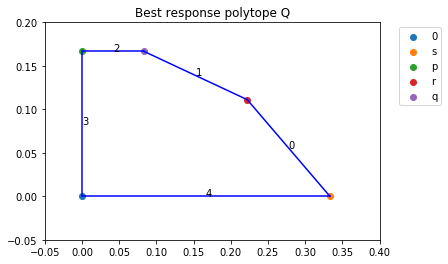

In [6]:
# Draw the best response polytope Q
from scipy.spatial import HalfspaceIntersection, ConvexHull
from itertools import combinations

halfspaces = np.empty((5, 3))
halfspaces[:3, :-1] = A
halfspaces[3:, :-1] = -np.eye(2)
halfspaces[:3, -1] = -1
halfspaces[3:, -1] = 0
feasible_point = np.array([0.05, 0.05])
hs = HalfspaceIntersection(halfspaces, feasible_point)

vertices_ind = np.empty((len(halfspaces), len(hs.intersections)), dtype = bool)
for i, constraint in enumerate(halfspaces):
    vertices_ind[i, :] = np.isclose(np.dot(np.hstack((hs.intersections,
                                                      np.ones((len(hs.intersections), 1)))),
                                           constraint), 
                                    0)

fig = plt.figure()
ax = fig.add_subplot('111')
xlim, ylim = (-0.05, 0.40), (-0.05, 0.20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

for ind in vertices_ind:
    vertices = hs.intersections[ind]
    ax.plot(vertices[:, 0], vertices[:, 1], c = 'b')
    
for i in range(len(halfspaces)):
    label_xyz = np.average(hs.intersections[vertices_ind[i]], axis=0)
    ax.text(*label_xyz, str(i))

pts_labels = ['0', 's', 'p', 'r', 'q']
for pt, l in zip(hs.intersections, pts_labels):
    ax.scatter(*pt, label=l)
plt.legend(bbox_to_anchor=(1.2, 1.0))
plt.title('Best response polytope Q')

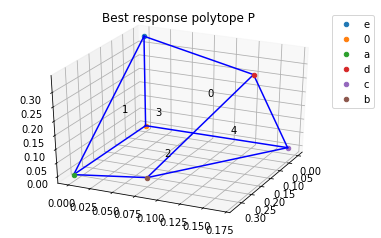

In [7]:
# Draw the best response polytope P
from mpl_toolkits.mplot3d import Axes3D

halfspaces = np.empty((5, 4))
halfspaces[:3, :-1] = -np.eye(3)
halfspaces[3:, :-1] = B
halfspaces[3:, -1] = -1
halfspaces[:3, -1] = 0
feasible_point = np.array([0.05, 0.05, 0.05])
hs = HalfspaceIntersection(halfspaces, feasible_point)

vertices_ind = np.empty((len(halfspaces), len(hs.intersections)), dtype = bool)
for i, constraint in enumerate(halfspaces):
    vertices_ind[i, :] = np.isclose(np.dot(np.hstack((hs.intersections,
                                                      np.ones((len(hs.intersections), 1)))),
                                           constraint), 
                                    0)

fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')

for i, j in combinations(range(vertices_ind.shape[0]), 2):
    vertices = hs.intersections[np.logical_and(vertices_ind[i, :], vertices_ind[j, :])]
    ax2.plot(vertices[:, 0], vertices[:, 1], vertices[:, 2], c = 'b')
    
for i in range(len(halfspaces)):
    label_xyz = np.average(hs.intersections[vertices_ind[i]], axis=0)
    ax2.text(*label_xyz, str(i))

pts_labels = ['e', '0', 'a', 'd', 'c', 'b']
for pt, l in zip(hs.intersections, pts_labels):
    ax2.scatter(*pt, label=l)

ax2.view_init(elev=30, azim=25)
plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.title('Best response polytope P')

$((x, v), (y, u)) \in \bar{P} \times \bar{Q}$ is *completely labeled* if every $k \in M \cup N$ appears as a label of either $(x, v)$ or $(y, u)$.

In the context of best response polyhedra and labels, we can define Nash equilibrium as:  
* $(x, y) \in \Delta^{M} \times \Delta^{N}$ is a Nash equilibrium if and only if $((x, v), (y, u))$ with $u = \text{max}_i (A y)_i$ and $v = \text{max}_j (B x)_j$ is completely labeled.

The transformed best response polytope is a special case where $u = v = 1$, and we have

* $(x, y) \in P \times Q$, $(x, y) \neq (\mathbf{0}, \mathbf{0})$, is an ("un-normalized") Nash equilibirum if and only if $(x, y)$ is completely labeled.

Note that $(x, y)$ is called as "un-normalized" because the elements in $x(y)$ does not sum up to $1$. We can normalize it to be a Nash equilibrium by

$$
x^* = \frac{1}{\mathbf{1}_M'x}x,\quad v = \frac{1}{\mathbf{1}_M'x}, \\
$$

and

$$
y^* = \frac{1}{\mathbf{1}_N'y}y,\quad u = \frac{1}{\mathbf{1}_N'y}, \\
$$

where $\mathbf{1}_M$ is a $m$-dimensional vector of ones, and $\mathbf{1}_N$ is a $n$-dimensional vector of ones. $(x^*, y^*)$ is the Nash equilibrium that we desire.

If the game is nondegenerate, then in $P(Q)$, each vertex have $m(n)$ labels. As completely labeled requires the pair to have $m+n$ distint labels, therefore the Nash equilibrium can only be found in pairs of vertices of two best response polyhedra. This implies that we can find a Nash equilibrium by enumerating each pair of vertices until we find a completely labeled one. However, the Lemke-Howson algorithm provides a more efficient way that avoids enumerating, which is called "pivoting", as we will see in the following.

### Lemke-Howson Algorithm for Finding Completely Labeled Pairs of Vertices

By all defintion, $(\mathbf{0}, \mathbf{0}) \in P \times Q$ is completely labeled. However, it is not a Nash equilibrium. We call it "artificial equilibrium". The Lemke-Howson algorithm starts from $(\mathbf{0}, \mathbf{0})$, and moves to a vertex next to the previous one by replacing the labels in $P$ and $Q$ in turn until it reaches a completely labeled pair, and thus an un-normalized Nash equilibrium is found.

In the previous example, this procedure would be as follows:

* $(\mathbf{0}, \mathbf{0})$ has labels {0, 1, 2}, {3, 4}
* $(\mathbf{0}, \mathbf{0}) \rightarrow (c, \mathbf{0})$ with label {0, 2, 4}, {3, 4}  
 Drop label 1 in $P$ (label to drop is arbitrarily chosen in the first step). Label 4 is picked up.
* $(c, \mathbf{0}) \rightarrow (c, p)$ with label {0, 2, 4}, {2, 3}  
 Drop label 4 in $Q$ as it is duplicated label of both $x$ and $y$. Label 2 is picked up.
* $(c, p) \rightarrow (d, p)$ with label {0, 3, 4}, {2, 3}  
 Drop label 2 in $P$ as it is duplicated label of both $x$ and $y$. Label 3 is picked up.
* ... ...
* Continue the procedure, until $(d, q)$ is achieved, which is completely labeled, and thus is a un-normalized Nash equilibrium.

### Complementary Pivoting

To implement the process of dropping and picking up labels, we introduce a technique called complementary pivoting, using slack variables denoted as $s_3, s_4, r_0, r_1, r_2$:

$$
\begin{matrix}
3 x_0 & + 2 x_1 & + 3 x_2 & + s_3 & & = 1\\
2 x_0 & + 6 x_1 & + x_2 & & + s_4 & = 1 \\
\\
r_0 & & & + 3 y_3 & + 3 y_4 & = 1\\
 & r_1 & & + 2 y_3 & + 5 y_4 & = 1 \\
 & & r_2 & & + 6 y_4 & = 1 
\end{matrix}
$$

$x \geq \mathbf{0}, s \geq \mathbf{0}, r \geq \mathbf{0}, y \geq \mathbf{0}.$

A solution $(x, s, r, y)$ is completely labeled if and only if  
$$
x^\prime r = 0, \quad y^\prime s = 0.
$$

Variables in $(x, s, r, y)$ are called *basic variables* if they are positive, and *nonbasic variables* if they are equal to $0$.

In this context, the geometric procedure showed above is equivalent to the algebraic procedure below, which we call *pivoting*.

During the process, what we need to keep track of are the indices of basic variables, the coefficients of linear equations systems, and the values on the right-hand side. The latter two terms can be saved in arrays, which we denote as *tableaux*.

$$
\text{tableau}_1 = 
\begin{bmatrix}
3 & 2 & 3 & 1 & 0 & 1 \\
2 & 6 & 1 & 0 & 1 & 1 \\
\end{bmatrix},
$$

and 

$$
\text{tableau}_2 =
\begin{bmatrix}
1 & 0 & 0 & 3 & 3 & 1 \\
0 & 1 & 0 & 2 & 5 & 1 \\
0 & 0 & 1 & 0 & 6 & 1 
\end{bmatrix},
$$

respectively.

In detail, the algorithm works as follows:

1. Given two tableaux and lists of basic variables, we start from $(\mathbf{0}, \mathbf{0})$ with the initial basic variables being $\{s_3, s_4\}$ and $\{r_0, r_1, r_2\}$.
2. Start with pivoting in $P$. The initial pivot indice can be arbitrarily chosen. Because of the nonnegativity constraint, the basic variable to be replaced is decided by minimum ratio test. Then update the tableau and basis of $P$ by dropping and adding basic variables.
3. Do pivoting in $Q$. Check whether the newly dropped basic variable has the same indice with the first added basic variable by initial pivoting. If it does, then the solution is completely labeled, and a Nash equilibrium has been found.
4. Repeat 3, until a Nash equilibirum is found. 

Note that we will not be in infinite loop, as the existence of Nash equilibrium is guaranteed.

### Implementation

First step, we create tableaux and lists of indices of basic variables. Note that the indices of the list of basic variables correspond to the row indices of tableau in order respectively. (the example below will show this in detail)

In [8]:
def initialize_tableaux(payoff_matrices):

    m, n = payoff_matrices[0].shape
    tableaux = (np.empty((n, m+n+1)), np.empty((m, n+m+1)))
    bases = (np.arange(m, m+n), np.arange(0, m))

    # Player 0
    # fill the tableau of Player0
    tableaux[0][:, :m] = payoff_matrices[1]
    tableaux[0][:, m:m+n] = np.identity(n)
    tableaux[0][:, -1] = 1

    # Player 1
    # create tableau of Player1
    tableaux[1][:, :m] = np.identity(m)
    tableaux[1][:, m:m+n] = payoff_matrices[0]
    tableaux[1][:, -1] = 1

    return tableaux, bases


tableaux, bases = initialize_tableaux([A, B])

In [9]:
tableaux

(array([[ 3.,  2.,  3.,  1.,  0.,  1.],
        [ 2.,  6.,  1.,  0.,  1.,  1.]]),
 array([[ 1.,  0.,  0.,  3.,  3.,  1.],
        [ 0.,  1.,  0.,  2.,  5.,  1.],
        [ 0.,  0.,  1.,  0.,  6.,  1.]]))

In [10]:
bases

(array([3, 4]), array([0, 1, 2]))

Consider the first list of indices of basic variables as example. The first element is $3$, which means the basic variable for first row of $\text{tableu}_1$ is $s_3$. Similarly, the basic variable for second row of $\text{tableu}_1$ is $s_4$. 

Define the `min_ratio_test` function for deciding the leaving basic variable, given the indice of the entering basic variable in a pivoting process.

In [11]:
def min_ratio_test(tableau, pivot):
    
    ind_nonpositive = tableau[:, pivot] <= 0
    # we suppress the "divide by zero" warning message
    with np.errstate(divide='ignore', invalid='ignore'):
        ratios = tableau[:, -1] / tableau[:, pivot]
    # leave out the pivots that have negative ratio
    ratios[ind_nonpositive] = np.inf
    # find the pivot with minimum ratio, under nonnegativity condition
    row_min = ratios.argmin()
    
    return row_min

The `Pivoting` function below is for updating the tableau after we decide the basic variables to be added and dropped.

In [12]:
def pivoting(tableau, pivot, pivot_row):
    """
    Perform a pivoting step.

    Parameters
    ----------
    tableau : ndarray(float, ndim=2)
        The tableau to be updated

    pivot : scalar(int)
        The indice of entering basic variable

    pivot_row: scalar(int)
        The row indice of tableau chosen by minimum ratio test
        the corresponding basic variable is going to be dropped

    Returns
    -------
    tableau : ndarray(float, ndim=2)
        The updated tableau

    """
    # Row indices except pivot_row
    ind = np.ones(tableau.shape[0], dtype=bool)
    ind[pivot_row] = False
    
    # Store the values in the pivot column, except for row_min
    # Made 2-dim by np.newaxis
    multipliers = tableau[ind, pivot, np.newaxis]
    
    # Update the tableau
    tableau[pivot_row, :] /= tableau[pivot_row, pivot]
    tableau[ind, :] -= tableau[pivot_row, :] * multipliers
    
    return tableau

In the following, we define the function for doing pivoting process recursively until a completely labeled pair is found, taking tableaux and lists of indices of basic variables as arguments.

In [13]:
def lemke_howson_tbl(tableaux, bases, init_pivot, max_iter=10**6):
    """
    Main body of the Lemke-Howson algorithm implementation.

    Parameters
    ----------
    tableaux : tuple(ndarray(float, ndim=2))
        Tuple of two arrays containing the tableaux, of shape (n, m+n+1)
        and (m, m+n+1), respectively. Modified in place.

    bases : tuple(ndarray(int, ndim=1))
        Tuple of two arrays containing the bases, of shape (n,) and
        (m,), respectively. Modified in place.

    init_pivot : scalar(int)
        Initial pivot, an integer k such that 0 <= k < m+n, where
        integers 0, ..., m-1 and m, ..., m+n-1 correspond to the actions
        of players 0 and 1, respectively.

    max_iter : scalar(int), optional(default=10**6)
        Maximum number of pivoting steps.

    Returns
    -------
    converged : bool
        Whether the pivoting terminated before `max_iter` was reached.

    """
    init_player = int((bases[0]==init_pivot).any())
    players = [init_player, 1 - init_player]

    pivot = init_pivot
    num_iter = 0
    
    converged = False

    while True:
        for i in players:
            # Determine the leaving variable
            row_min = min_ratio_test(tableaux[i], pivot)
            
            # Pivoting step: modify tableau in place
            pivoting(tableaux[i], pivot, row_min)
            
            # Update the basic variables and the pivot
            bases[i][row_min], pivot = pivot, bases[i][row_min]
            
            num_iter += 1
            
            if pivot == init_pivot:
                converged = True
                break
            if num_iter >= max_iter:
                return converged
        else:
            continue
        break

    return converged

After the completely pair is found, we can get mixed actions from tableux and lists of indices of basic variables.

In [14]:
def get_mixed_actions(tableaux, bases):

    m, n = tableaux[1].shape[0], tableaux[0].shape[0]
    
    # get the mixed actions and normalize them
    out_dtype = np.result_type(*tableaux)
    out = np.zeros(m+n, dtype=out_dtype)
    for pl, (start, stop) in enumerate(zip((0, m),
                                           (m, m+n))):
        ind = bases[pl] < stop if pl == 0 else start <= bases[pl]
        out[bases[pl][ind]] = tableaux[pl][ind, -1]
        out[bases[pl][ind]] /= sum(out[bases[pl][ind]])

    return out[:m], out[m:]

Finally we wrap all the procedures together, and define a function called `lemke_howson_numpy` which takes `NormalFormGame` as argument.

In [15]:
def lemke_howson_numpy(g, init_pivot=0, max_iter=10**6):
    """
    Wrap the procedure of initializing tableaux, complementary pivoting,
    and get the mixed actions.

    Parameters
    ----------
    g : NormalFormGame
        NormalFormGame instance with 2 players.

    init_pivot : scalar(int), optional(default=0)
        Initial pivot, an integer k such that 0 <= k < m+n, where
        integers 0, ..., m-1 and m, ..., m+n-1 correspond to the actions
        of players 0 and 1, respectively.

    max_iter : scalar(int), optional(default=10**6)
        Maximum number of pivoting steps.

    Returns
    -------
    NE : tuple(ndarray(float, ndim=1)) or None
        Tuple of computed Nash equilibrium mixed actions.
        If no Nash equilibrium is found, return None.

    """
    payoff_matrices = tuple(g.players[i].payoff_array for i in range(2))
    tableaux, bases = initialize_tableaux(payoff_matrices)
    
    converged = lemke_howson_tbl(tableaux, bases, init_pivot, max_iter)
    if converged:
        NE = get_mixed_actions(tableaux, bases)
        return NE
    else:
        print("Not converged")
        return None

In [16]:
# create normal form game
g = gt.NormalFormGame((gt.Player(A), gt.Player(B)))

init_pivot = 1
lemke_howson_numpy(g, init_pivot, 10)

(array([ 0.        ,  0.33333333,  0.66666667]),
 array([ 0.33333333,  0.66666667]))

As it shows, one Nash equilibrium for this nondegenerate game is:

$$
x = (0, \frac{1}{3}, \frac{2}{3}), \quad y = (\frac{1}{3}, \frac{2}{3}), \\
u = \frac{8}{3}, \quad v = 4.
$$

We can use the `lemke_howson` routine from `quantecon.py`, which wraps the procedure of creating tableaus and indice lists of basic variables, pivoting, and normalizing the found Nash equilibrium. 

In [17]:
# use lemke_howson with initial pivot being 1
gt.lemke_howson(g, init_pivot=1)

(array([ 0.        ,  0.33333333,  0.66666667]),
 array([ 0.33333333,  0.66666667]))

# Degenerate Games

In a degenerate game, the minimum ratio test may have more than one minimizers. In this case, arbitrary tie breaking may lead to cycling, causing the algorithm to fall into an infinite loop.

For example, consider a game with the payoff matrices being $C$ and $D$ for Player 0 and 1 respectively:

$$
C =
\begin{bmatrix}
0 & 0 & 0 \\
0 & 1 & 1 \\
1 & 1 & 0
\end{bmatrix},
\quad
D =
\begin{bmatrix}
1 & 0 & 1 \\
1 & 1 & 0 \\
0 & 0 & 2
\end{bmatrix}.
$$

As `numpy.argmin()` returns the first indice when there is a tie in a 1-dimensional array, if we still use `lemke_howson_numpy` which utilize `min_ratio_test`, it may fail to find a Nash equilirbium properly because of cycling.

In [18]:
C = np.array([[0, 0, 0],
              [0, 1, 1],
              [1, 1, 0]])
D = np.array([[1, 0, 1],
              [1, 1, 0],
              [0, 0, 2]])

g = gt.NormalFormGame((gt.Player(C), gt.Player(D)))
lemke_howson_numpy(g, init_pivot=0, max_iter=100)

Not converged


As such, we replace the minimum ratio test with the lexico-minimum ratio test for determining the leaving basic variable in degenerate games.

Note that the original system can be written as 

$$
D x + I s = \mathbf{1},
$$

where $x$ is the mixed action, and $s$ is the slack variable vector.

The lexico-minimum ratio test introduces $(\epsilon, \epsilon^1, \cdots, \epsilon^n)^\prime$ to the right hand:

$$
D x + I s = \mathbf{1} + (\epsilon, \epsilon^1, \cdots, \epsilon^n)^\prime.
$$

After any number of pivoting steps, the system can be representd by pre-multiplying a inverse of a basic matrix $P$:

$$
P D x + P I s = P \mathbf{1} + P (\epsilon, \epsilon^1, \cdots, \epsilon^n)^\prime.
$$

Write $p_{i0} + p_{i1} ε^1 + ··· + p_{in} ε^n$ for the ith entry of the vector in the right hand, and let $d_i$ be the ith row of the pivoting column.

The lexico-minimum ratio test break a tie by comparing the $p_{ik}$ and $p_{jk}$ in order:

* Choose the minimizers of $p_{i0} / d_{i}$.
* If more than one, among them choose the minimizers of $p_{i1} / d_{i}$.
* repeat this until there is only one minimizer

Note that when implementing this in code, the matrix $P$ is the same with the coefficient matrix of slack variables, and thus we do not need to extend tableau to record more information.

As the `lemke_howson` routine in `quantecon.py` always uses lexico-minimum ratio test, there is no need to be concerned with nondegenerate games when using it.

In [19]:
gt.lemke_howson(g, init_pivot=0)

(array([ 0.        ,  0.66666667,  0.33333333]), array([ 0.,  1.,  0.]))

# Comparing quantecon.lemke_howson and lemke_howson_numpy

The `lemke_howson` routine in `quantecon.game_thoery` is accelerated by `numba`, and therefore, the speed of finding a Nash equilibrium is much faster than `lemke_howson_numpy`. Below is a comparison of these two functions.

In [20]:
import timeit

In [21]:
ns = 10
g = gt.random_game((n, n))
lemke_howson_numpy(g)
gt.lemke_howson(g)

(array([ 0.,  1.]), array([ 0.,  1.]))

In [22]:
ns = [10, 11, 12]
seed = 1234
for n in ns:
    print("{0} by {0} payoff matrices: ".format(n))
    g = gt.random_game((n, n), random_state=seed)
    print("lemke_howson_numpy : ", end='')
    %timeit lemke_howson_numpy(g)
    print("gt.lemke_howson : ", end='')
    %timeit gt.lemke_howson(g)
    print("\n")

10 by 10 payoff matrices: 
lemke_howson_numpy : 1000 loops, best of 3: 329 µs per loop
gt.lemke_howson : 10000 loops, best of 3: 23.8 µs per loop


11 by 11 payoff matrices: 
lemke_howson_numpy : 1000 loops, best of 3: 373 µs per loop
gt.lemke_howson : 10000 loops, best of 3: 25.5 µs per loop


12 by 12 payoff matrices: 
lemke_howson_numpy : 1000 loops, best of 3: 565 µs per loop
gt.lemke_howson : 10000 loops, best of 3: 25.9 µs per loop


